*Homework by Samoshyn Andriy*

In [35]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from tqdm import tqdm

import time
import os
import PIL.Image as Image
from IPython.display import display

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device))

cuda:0
Tesla P100-PCIE-16GB


# Load and base transform

In [2]:
path_base = "../input/stanford-car-dataset-by-classes-folder/car_data/car_data/"

Let's define our training and test (validation) datasets. We also give all the images to a uniform size. To normalize the data, you need to use **transforms.ToTensor()**:

> Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]

In [13]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((400, 400)),
        transforms.ToTensor()
    ]),
    'test': transforms.Compose([
        transforms.Resize((400, 400)),
        transforms.ToTensor()
    ]),
}

batch_size = 32

image_datasets = {x: torchvision.datasets.ImageFolder(root=path_base+x, transform=data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

In [14]:
print('Train data, number of images: ', len(df_train))
print('Test data, number of images: ', len(df_test))

Train data, number of images:  8144
Test data, number of images:  8041


Here we train our model, after each epoch, we test the model on the test data to see how it's going.

In [9]:
def train_model(model, criterion, optimizer, scheduler, n_epochs = 5):
    
    losses = []
    accuracies = []
    test_accuracies = []
    test_losses = []
    
    model.to(device)
    model.train()
    for epoch in range(n_epochs):
        print(f'Epoch {epoch}/{n_epochs-1}')
        print('-' * 10)
        running_loss = 0.0
        running_correct = 0.0
        total = 0.0
        
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                losses.append(epoch_loss)
                accuracies.append(epoch_acc)
            else:
                test_losses.append(epoch_loss)
                test_accuracies.append(epoch_acc)
            print(f'{phase} Loss: {epoch_loss} Acc: {epoch_acc}')
        print()
        
    return model, losses, accuracies, test_losses, test_accuracies

In [10]:
def visual(training_losses, training_accs, test_losses, test_accs, name):

    f, ax = plt.subplots(2,2, figsize = (12, 8))
    ax[0, 0].plot(training_losses)
    ax[0, 0].set_title("Training loss")
    ax[0, 1].plot(training_accs)
    ax[0, 1].set_title("Training acc")
    ax[1, 0].plot(test_losses)
    ax[1, 0].set_title("Test loss")
    ax[1, 1].plot(test_accs)
    ax[1, 1].set_title("Test acc")
    f.suptitle(f'Train visualise {name} 100\'s of batches')
    plt.show()

# Define basic CNN

> Let's define convolutional neural networks with 1 convolution.

In [7]:
class ConvNet1(nn.Module):
    def __init__(self):
        super(ConvNet1, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
    
        self.fc1 = nn.Linear(396010, 200)

        self.fc2 = nn.Linear(200, 196)
        

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x
    
net1 = ConvNet1()
print(net1)

ConvNet1(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=396010, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=196, bias=True)
)


> Define convolutional neural networks with 2 convolutions.

In [8]:
class ConvNet2(nn.Module):
    def __init__(self):
        super(ConvNet2, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 20, 3)
        self.pool2 = nn.MaxPool2d(2, 2)

    
        self.fc1 = nn.Linear(192080, 200)

        self.fc2 = nn.Linear(200, 196)
        

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x
    
net2 = ConvNet2()
print(net2)

ConvNet2(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=192080, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=196, bias=True)
)


> Define convolutional neural networks with 3 convolutions.

In [9]:
class ConvNet3(nn.Module):
    def __init__(self):
        super(ConvNet3, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 20, 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(20, 30, 3)
        self.pool3 = nn.MaxPool2d(2, 2)

    
        self.fc1 = nn.Linear(69120, 200)

        self.fc2 = nn.Linear(200, 196)
        

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x
    
net3 = ConvNet3()
print(net3)

ConvNet3(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(20, 30, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=69120, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=196, bias=True)
)


> Define convolutional neural networks with 4 convolutions.

In [10]:
class ConvNet4(nn.Module):
    def __init__(self):
        super(ConvNet4, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 20, 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(20, 30, 3)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(30, 50, 3)
        self.pool4 = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(26450, 200)

        self.fc2 = nn.Linear(200, 196)
        

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.pool4(F.relu(self.conv4(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x
    
net4 = ConvNet4()
print(net4)

ConvNet4(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(20, 30, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(30, 50, kernel_size=(3, 3), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=26450, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=196, bias=True)
)


Before training each model, you need to define an optimizer and a scheduler.

#### Model 1. Baseline ####
Epoch 0/3
----------
train Loss: 5.279878569492422 Acc: 0.00712180746561886
test Loss: 5.275568519357929 Acc: 0.006466857356050242

Epoch 1/3
----------
train Loss: 5.269136885060308 Acc: 0.007981335952848723
test Loss: 5.265819494173666 Acc: 0.006466857356050242

Epoch 2/3
----------
train Loss: 5.2450858755055485 Acc: 0.01043713163064833
test Loss: 5.249764976743412 Acc: 0.011441363014550428

Epoch 3/3
----------
train Loss: 5.195653002950672 Acc: 0.016822200392927308
test Loss: 5.240210300623933 Acc: 0.012436264146250466



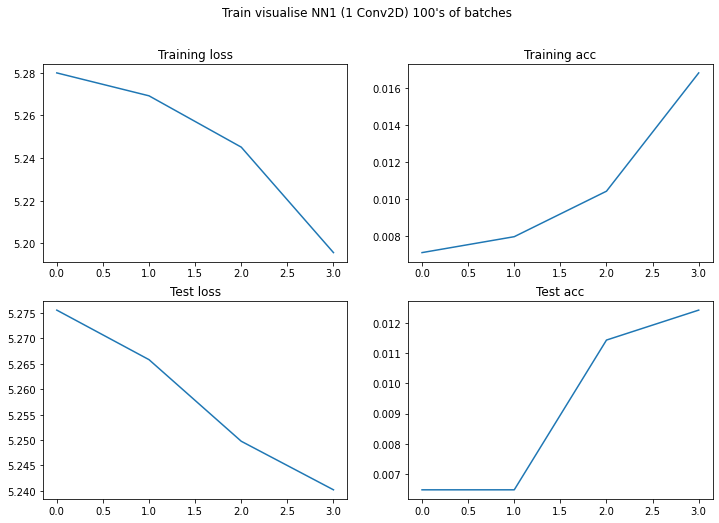

#### Model 2. Baseline ####
Epoch 0/3
----------
train Loss: 5.281489058421497 Acc: 0.005279960707269155
test Loss: 5.277765142281633 Acc: 0.0053475935828877

Epoch 1/3
----------
train Loss: 5.276988172812171 Acc: 0.006139489194499017
test Loss: 5.27691012326646 Acc: 0.004477055092650168

Epoch 2/3
----------
train Loss: 5.275620492361852 Acc: 0.0054027504911591355
test Loss: 5.27501804635027 Acc: 0.0053475935828877

Epoch 3/3
----------
train Loss: 5.273424763108049 Acc: 0.006016699410609037
test Loss: 5.274541367169207 Acc: 0.005471956224350205



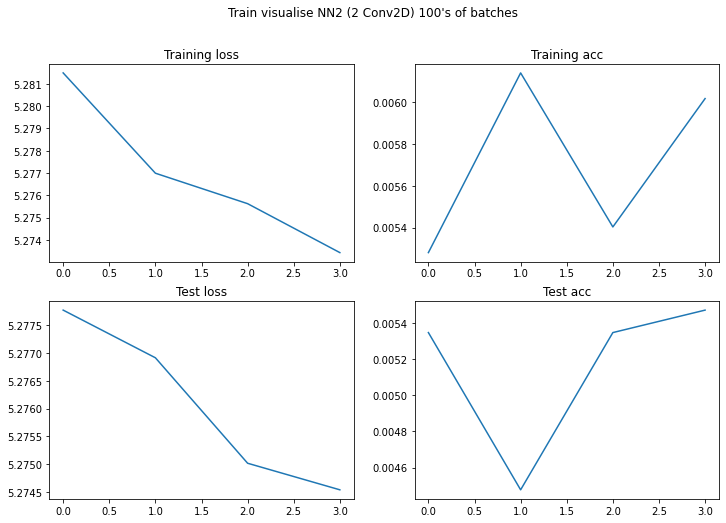

#### Model 3. Baseline ####
Epoch 0/3
----------
train Loss: 5.279304290801463 Acc: 0.005034381139489194
test Loss: 5.2779096423830945 Acc: 0.005471956224350205

Epoch 1/3
----------
train Loss: 5.278223416191656 Acc: 0.005771119842829076
test Loss: 5.277627036696331 Acc: 0.005471956224350205

Epoch 2/3
----------
train Loss: 5.277848118180611 Acc: 0.005525540275049115
test Loss: 5.277318895819353 Acc: 0.005471956224350205

Epoch 3/3
----------
train Loss: 5.277092979558558 Acc: 0.005525540275049115
test Loss: 5.277291258062508 Acc: 0.005471956224350205



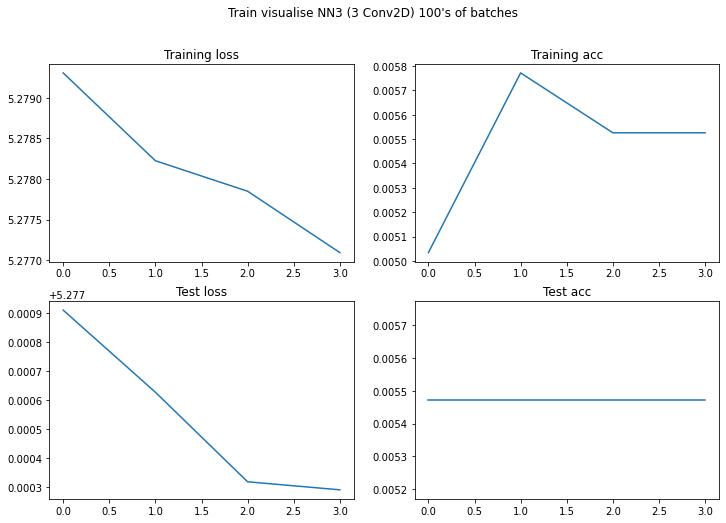

#### Model 4. Baseline ####
Epoch 0/3
----------
train Loss: 5.27941383781508 Acc: 0.005034381139489194
test Loss: 5.278386143839874 Acc: 0.0048501430170376815

Epoch 1/3
----------
train Loss: 5.278666966556332 Acc: 0.003929273084479371
test Loss: 5.277957881865343 Acc: 0.0069643079219002604

Epoch 2/3
----------
train Loss: 5.278251356600778 Acc: 0.004297642436149312
test Loss: 5.277589117201269 Acc: 0.0067155826389752515

Epoch 3/3
----------
train Loss: 5.2775202678088355 Acc: 0.00699901768172888
test Loss: 5.277543848982025 Acc: 0.006093769431662728



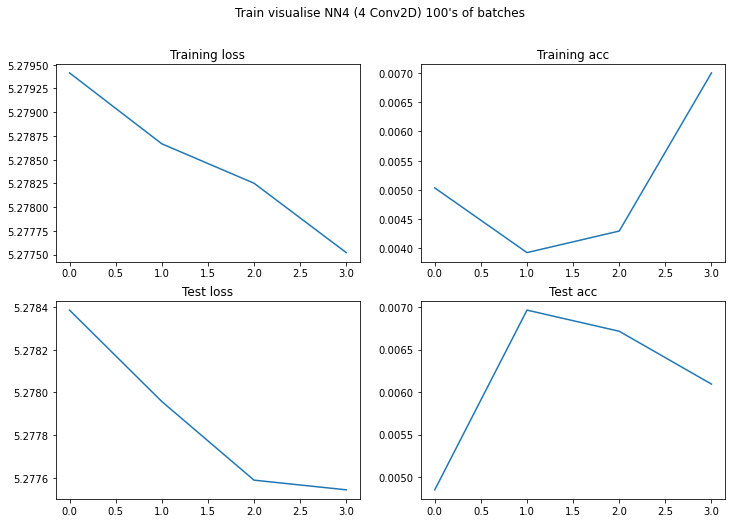

In [15]:
learning_rate = 0.001
models = [net1, net2, net3, net4]

for i in range(len(models)):
    print(f'#### Model {i+1}. Baseline ####')
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(models[i].parameters(), lr=learning_rate, momentum=0.9)
    lrscheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
    model_ft, training_losses, training_accs, test_losses, test_accs = train_model(models[i], criterion, optimizer, lrscheduler, n_epochs=4)
    visual(training_losses, training_accs, test_losses, test_accs, f'NN{i+1} ({i+1} Conv2D)')

As we can see, models already by the 3rd epoch give better accuracy than random selection. This means that **models can learn, but hardly too well**. This can be seen from the rate at which the loss decreases. Such a slow decrease in the loss can be associated with lerning rate. Let's try to change it in the next iteration. Therefore, I see no reason to train the simplest models on a large number of epochs, because they will not be able to give a good result.

# Add Dropouts

Based on the visualization of the latest models, it is likely to be overfitting. Therefore, after each set of layers for convolution add a Dropout. The excluded neurons will not contribute to the learning process at any stage of the backpropagation algorithm.

In [28]:
class ConvNet11(nn.Module):
    def __init__(self):
        super(ConvNet11, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.drop1 = nn.Dropout(p=0.2)
        self.fc1 = nn.Linear(396010, 200)

        self.fc2 = nn.Linear(200, 196)
        

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.drop1(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x
    
net1 = ConvNet11()
print(net1)

ConvNet11(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=396010, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=196, bias=True)
)


In [29]:
class ConvNet22(nn.Module):
    def __init__(self):
        super(ConvNet22, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.drop1 = nn.Dropout(p=0.2)
        self.conv2 = nn.Conv2d(10, 20, 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.drop2 = nn.Dropout(p=0.2)
    
        self.fc1 = nn.Linear(192080, 200)

        self.fc2 = nn.Linear(200, 196)
        

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.drop1(x)
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.drop2(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x
    
net2 = ConvNet22()
print(net2)

ConvNet22(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.2, inplace=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=192080, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=196, bias=True)
)


In [30]:
class ConvNet33(nn.Module):
    def __init__(self):
        super(ConvNet33, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.drop1 = nn.Dropout(p=0.2)
        self.conv2 = nn.Conv2d(10, 20, 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.drop2 = nn.Dropout(p=0.2)
        self.conv3 = nn.Conv2d(20, 30, 3)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.drop3 = nn.Dropout(p=0.2)
    
        self.fc1 = nn.Linear(69120, 200)

        self.fc2 = nn.Linear(200, 196)
        

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.drop1(x)
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.drop2(x)
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.drop3(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x
    
net3 = ConvNet33()
print(net3)

ConvNet33(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.2, inplace=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout(p=0.2, inplace=False)
  (conv3): Conv2d(20, 30, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop3): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=69120, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=196, bias=True)
)


In [31]:
class ConvNet44(nn.Module):
    def __init__(self):
        super(ConvNet44, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.drop1 = nn.Dropout(p=0.2)
        self.conv2 = nn.Conv2d(10, 20, 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.drop2 = nn.Dropout(p=0.2)
        self.conv3 = nn.Conv2d(20, 30, 3)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.drop3 = nn.Dropout(p=0.2)
        self.conv4 = nn.Conv2d(30, 50, 3)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.drop4 = nn.Dropout(p=0.2)
        
        self.fc1 = nn.Linear(26450, 200)

        self.fc2 = nn.Linear(200, 196)
        

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.drop1(x)
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.drop2(x)
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.drop3(x)
        x = self.pool4(F.relu(self.conv4(x)))
        x = self.drop4(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x
    
net4 = ConvNet44()
print(net4)

ConvNet44(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.2, inplace=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout(p=0.2, inplace=False)
  (conv3): Conv2d(20, 30, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop3): Dropout(p=0.2, inplace=False)
  (conv4): Conv2d(30, 50, kernel_size=(3, 3), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop4): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=26450, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=196, bias=True)
)


#### Model 1. Add Dropout ####
Epoch 0/4
----------
train Loss: 5.25271965337877 Acc: 0.008472495088408643
test Loss: 5.194859512942508 Acc: 0.01256062678771297

Epoch 1/4
----------
train Loss: 5.138250106444294 Acc: 0.019155206286836934
test Loss: 5.1387650286168425 Acc: 0.014301703768188035

Epoch 2/4
----------
train Loss: 4.972746500566104 Acc: 0.03536345776031434
test Loss: 5.14410140576343 Acc: 0.01902748414376321

Epoch 3/4
----------
train Loss: 4.467361189761658 Acc: 0.10388015717092337
test Loss: 5.252242216763249 Acc: 0.021763462255938313

Epoch 4/4
----------
train Loss: 4.139827535288273 Acc: 0.1569253438113949
test Loss: 5.34959498899906 Acc: 0.02437507772665091



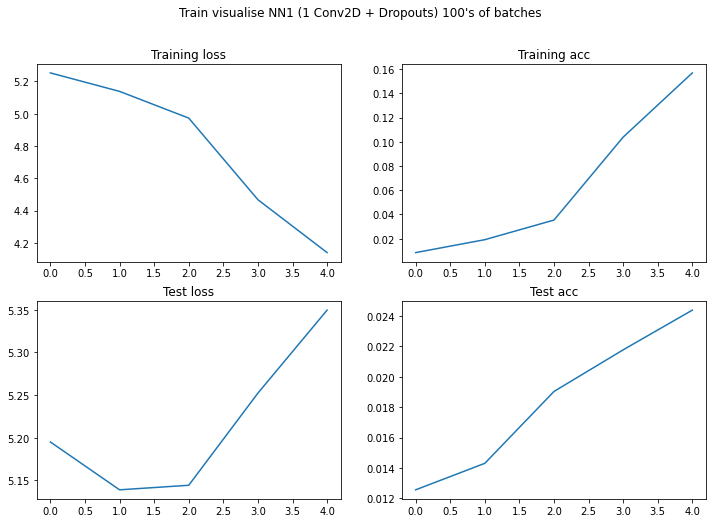

#### Model 2. Add Dropout ####
Epoch 0/4
----------
train Loss: 5.2826788355184675 Acc: 0.004666011787819253
test Loss: 5.277698468219106 Acc: 0.005969406790200223

Epoch 1/4
----------
train Loss: 5.278398564381777 Acc: 0.007981335952848723
test Loss: 5.276032088808331 Acc: 0.008456659619450316

Epoch 2/4
----------
train Loss: 5.275450970662835 Acc: 0.008349705304518663
test Loss: 5.271408935518885 Acc: 0.008456659619450316

Epoch 3/4
----------
train Loss: 5.2583573450039784 Acc: 0.008840864440078585
test Loss: 5.261559987539617 Acc: 0.01019773659992538

Epoch 4/4
----------
train Loss: 5.236807815686658 Acc: 0.011419449901768172
test Loss: 5.248768731560699 Acc: 0.011192637731625418



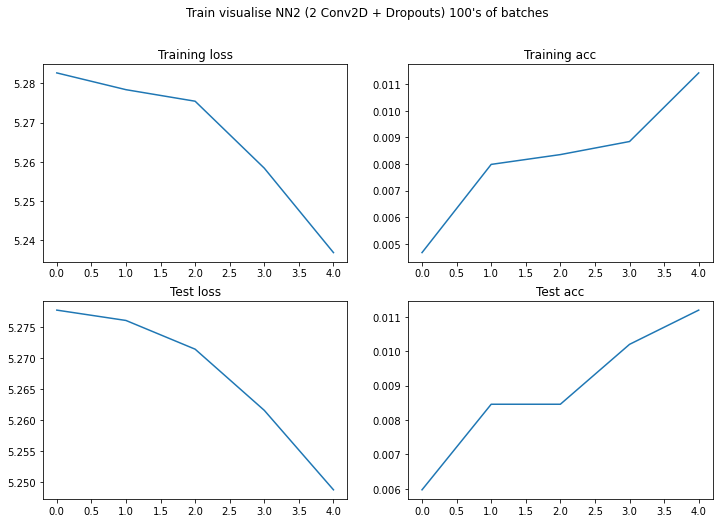

#### Model 3. Add Dropout ####
Epoch 0/4
----------
train Loss: 5.2806440683151274 Acc: 0.00699901768172888
test Loss: 5.277508497860817 Acc: 0.008456659619450316

Epoch 1/4
----------
train Loss: 5.271982925579918 Acc: 0.009454813359528486
test Loss: 5.2459045838781915 Acc: 0.012436264146250466

Epoch 2/4
----------
train Loss: 5.200201465479283 Acc: 0.013138506876227897
test Loss: 5.167683050357025 Acc: 0.01256062678771297

Epoch 3/4
----------
train Loss: 5.095532755486389 Acc: 0.020260314341846757
test Loss: 5.132399151387788 Acc: 0.015420967541350578

Epoch 4/4
----------
train Loss: 5.043071433931062 Acc: 0.02578585461689587
test Loss: 5.117335962991248 Acc: 0.01840567093645069



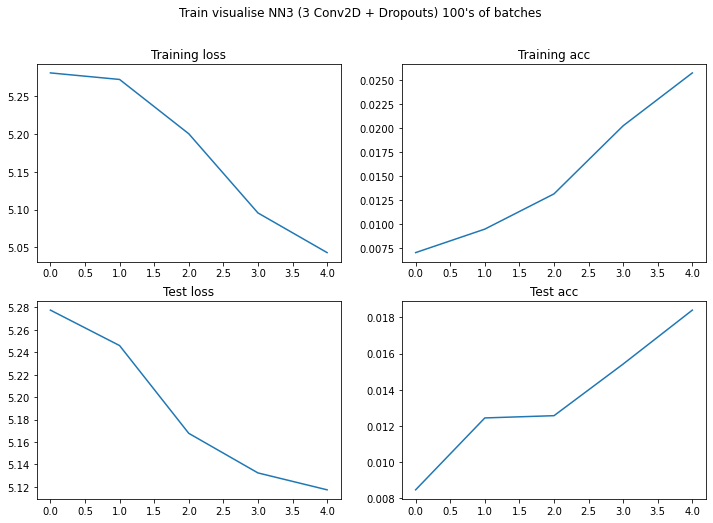

#### Model 4. Add Dropout ####
Epoch 0/4
----------
train Loss: 5.280442709070292 Acc: 0.005893909626719056
test Loss: 5.277358304177806 Acc: 0.008456659619450316

Epoch 1/4
----------
train Loss: 5.2776510345444 Acc: 0.008349705304518663
test Loss: 5.276104414882596 Acc: 0.008456659619450316

Epoch 2/4
----------
train Loss: 5.271341662041565 Acc: 0.008349705304518663
test Loss: 5.2681515342841445 Acc: 0.008456659619450316

Epoch 3/4
----------
train Loss: 5.238197262020148 Acc: 0.011419449901768172
test Loss: 5.256487595413828 Acc: 0.011565725656012932

Epoch 4/4
----------
train Loss: 5.213412303587308 Acc: 0.012156188605108054
test Loss: 5.24369618145777 Acc: 0.012684989429175475



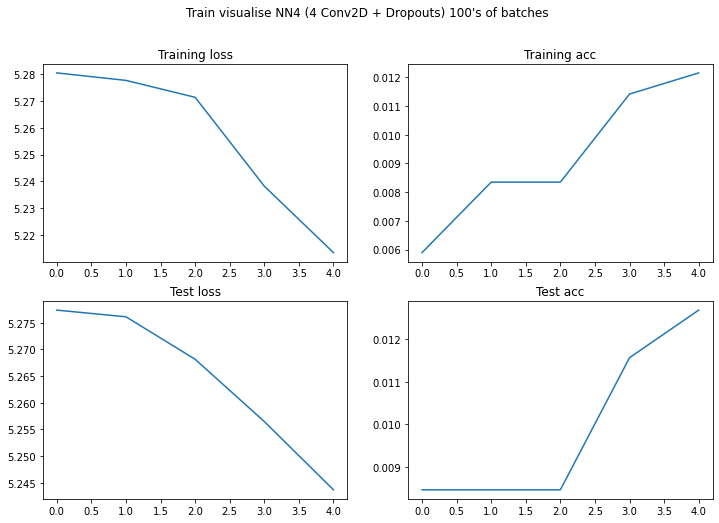

In [32]:
learning_rate = 0.01
models = [net1, net2, net3, net4]

for i in range(len(models)):
    print(f'#### Model {i+1}. Add Dropout ####')
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(models[i].parameters(), lr=learning_rate, momentum=0.9)
    lrscheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
    model_ft, training_losses, training_accs, test_losses, test_accs = train_model(models[i], criterion, optimizer, lrscheduler, n_epochs=5)
    visual(training_losses, training_accs, test_losses, test_accs, f'NN{i+1} ({i+1} Conv2D + Dropouts)')

After adding dropout layers, the loss curves are more similar to each other, i.e. the model behaves better on test data. But still there is underfitting on the current number of epochs. While researching transformation methods, it was found that after **tensor normalization (0.5 0.5 0.5)(0.5 0.5 0.5)**, the model is better to learn **(15-30% better than usual)**, but we will not apply it in this tutorial.

# Add BatchNorm

Now let's try to add **BatchNorm** layers to speed up and stabilize the training of the neural network. It does this by normalizing the input layer by re-centering and re-scaling.

During training, the layer normalizes its output using the mean and standard deviation of the current batch of inputs.

In [63]:
class ConvNet111(nn.Module):
    def __init__(self):
        super(ConvNet111, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.bn1 = nn.BatchNorm2d(10)
        self.drop1 = nn.Dropout(p=0.2)
        self.fc1 = nn.Linear(396010, 200)

        self.fc2 = nn.Linear(200, 196)
        

    def forward(self, x):
        x = self.bn1(self.pool1(F.relu(self.conv1(x))))
        x = self.drop1(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x
    
net1 = ConvNet111()
print(net1)

ConvNet111(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop1): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=396010, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=196, bias=True)
)


In [64]:
class ConvNet222(nn.Module):
    def __init__(self):
        super(ConvNet222, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.bn1 = nn.BatchNorm2d(10)
        self.drop1 = nn.Dropout(p=0.2)
        self.conv2 = nn.Conv2d(10, 20, 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.bn2 = nn.BatchNorm2d(20)
        self.drop2 = nn.Dropout(p=0.2)
    
        self.fc1 = nn.Linear(192080, 200)

        self.fc2 = nn.Linear(200, 196)
        

    def forward(self, x):
        x = self.bn1(self.pool1(F.relu(self.conv1(x))))
        x = self.drop1(x)
        x = self.bn2(self.pool2(F.relu(self.conv2(x))))
        x = self.drop2(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x
    
net2 = ConvNet222()
print(net2)

ConvNet222(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop1): Dropout(p=0.2, inplace=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop2): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=192080, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=196, bias=True)
)


In [4]:
class ConvNet333(nn.Module):
    def __init__(self):
        super(ConvNet333, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.bn1 = nn.BatchNorm2d(10)
        self.drop1 = nn.Dropout(p=0.2)
        self.conv2 = nn.Conv2d(10, 20, 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.bn2 = nn.BatchNorm2d(20)
        self.drop2 = nn.Dropout(p=0.2)
        self.conv3 = nn.Conv2d(20, 30, 3)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.bn3 = nn.BatchNorm2d(30)
        self.drop3 = nn.Dropout(p=0.2)
    
        self.fc1 = nn.Linear(69120, 200)

        self.fc2 = nn.Linear(200, 196)
        

    def forward(self, x):
        x = self.bn1(self.pool1(F.relu(self.conv1(x))))
        x = self.drop1(x)
        x = self.bn2(self.pool2(F.relu(self.conv2(x))))
        x = self.drop2(x)
        x = self.bn3(self.pool3(F.relu(self.conv3(x))))
        x = self.drop3(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x
    
net3 = ConvNet333()
print(net3)

ConvNet333(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop1): Dropout(p=0.2, inplace=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop2): Dropout(p=0.2, inplace=False)
  (conv3): Conv2d(20, 30, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn3): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop3): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=69120, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=196, bias=True)
)


In [5]:
class ConvNet444(nn.Module):
    def __init__(self):
        super(ConvNet444, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.bn1 = nn.BatchNorm2d(10)
        self.drop1 = nn.Dropout(p=0.2)
        self.conv2 = nn.Conv2d(10, 20, 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.bn2 = nn.BatchNorm2d(20)
        self.drop2 = nn.Dropout(p=0.2)
        self.conv3 = nn.Conv2d(20, 30, 3)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.bn3 = nn.BatchNorm2d(30)
        self.drop3 = nn.Dropout(p=0.2)
        self.conv4 = nn.Conv2d(30, 50, 3)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.bn4 = nn.BatchNorm2d(50)
        self.drop4 = nn.Dropout(p=0.2)
        
        self.fc1 = nn.Linear(26450, 200)

        self.fc2 = nn.Linear(200, 196)
        

    def forward(self, x):
        x = self.bn1(self.pool1(F.relu(self.conv1(x))))
        x = self.drop1(x)
        x = self.bn2(self.pool2(F.relu(self.conv2(x))))
        x = self.drop2(x)
        x = self.bn3(self.pool3(F.relu(self.conv3(x))))
        x = self.drop3(x)
        x = self.bn4(self.pool4(F.relu(self.conv4(x))))
        x = self.drop4(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x
    
net4 = ConvNet444()
print(net4)

ConvNet444(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop1): Dropout(p=0.2, inplace=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop2): Dropout(p=0.2, inplace=False)
  (conv3): Conv2d(20, 30, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn3): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop3): Dropout(p=0.2, inplace=False)
  (conv4): Conv2d(30, 50, kernel_size=(3, 3), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn4): Ba

#### Model 1. Add BatchNorm  ####
Epoch 0/4
----------
train Loss: 5.356983261633013 Acc: 0.01092829076620825
test Loss: 5.2320485244919865 Acc: 0.016788956597438127

Epoch 1/4
----------
train Loss: 3.6983758405524294 Acc: 0.3171660117878192
test Loss: 6.2267380218543815 Acc: 0.015669692824275588

Epoch 2/4
----------
train Loss: 0.8357821899687612 Acc: 0.8692288801571708
test Loss: 6.34565942890237 Acc: 0.01977365999253824

Epoch 3/4
----------
train Loss: 0.08713860349813823 Acc: 0.9918958742632612
test Loss: 6.19445371171192 Acc: 0.022509638104713344

Epoch 4/4
----------
train Loss: 0.05886220049080101 Acc: 0.9949656188605107
test Loss: 6.2246973689790535 Acc: 0.023380176594950876



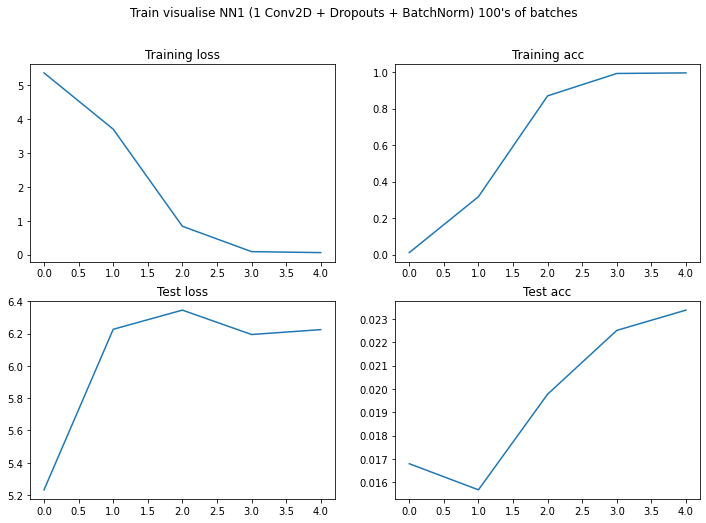

#### Model 2. Add BatchNorm  ####
Epoch 0/4
----------
train Loss: 5.3054972865960925 Acc: 0.015962671905697445
test Loss: 5.891067772329098 Acc: 0.011938813580400446

Epoch 1/4
----------
train Loss: 3.456026190624724 Acc: 0.31262278978388996
test Loss: 6.933063049159852 Acc: 0.014923516975500558

Epoch 2/4
----------
train Loss: 0.544670559978204 Acc: 0.9199410609037327
test Loss: 6.618617458554616 Acc: 0.02213655018032583

Epoch 3/4
----------
train Loss: 0.047198097106281575 Acc: 0.9980353634577602
test Loss: 6.321151971135058 Acc: 0.027111055838826014

Epoch 4/4
----------
train Loss: 0.035728544864093624 Acc: 0.9982809430255402
test Loss: 6.276100238984593 Acc: 0.02860340753637607



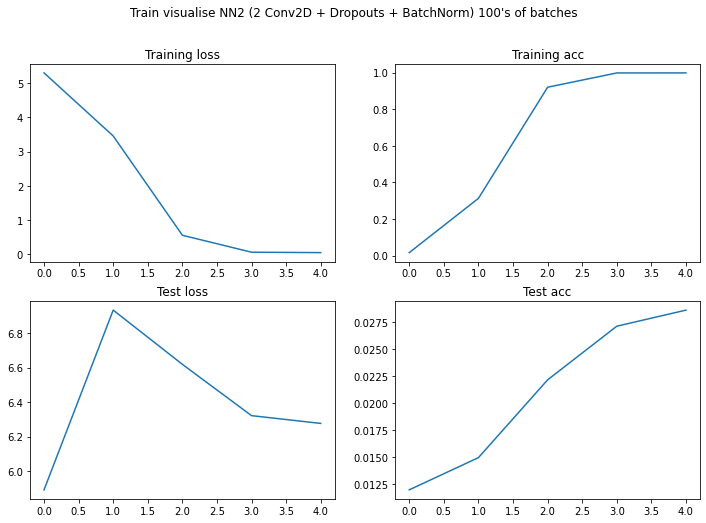

#### Model 3. Add BatchNorm  ####
Epoch 0/4
----------
train Loss: 5.239452395785769 Acc: 0.016331041257367385
test Loss: 5.346290722398553 Acc: 0.01691331923890063

Epoch 1/4
----------
train Loss: 4.34089251351497 Acc: 0.1299115913555992
test Loss: 5.303197147745114 Acc: 0.02512125357542594

Epoch 2/4
----------
train Loss: 2.7618963029857704 Acc: 0.47323182711198425
test Loss: 5.3223396795719005 Acc: 0.030344484516851136

Epoch 3/4
----------
train Loss: 1.0052557291356894 Acc: 0.8966110019646365
test Loss: 5.244271582001078 Acc: 0.036686979231438877

Epoch 4/4
----------
train Loss: 0.8327820318621127 Acc: 0.9265717092337917
test Loss: 5.261846193670115 Acc: 0.03768188036313891



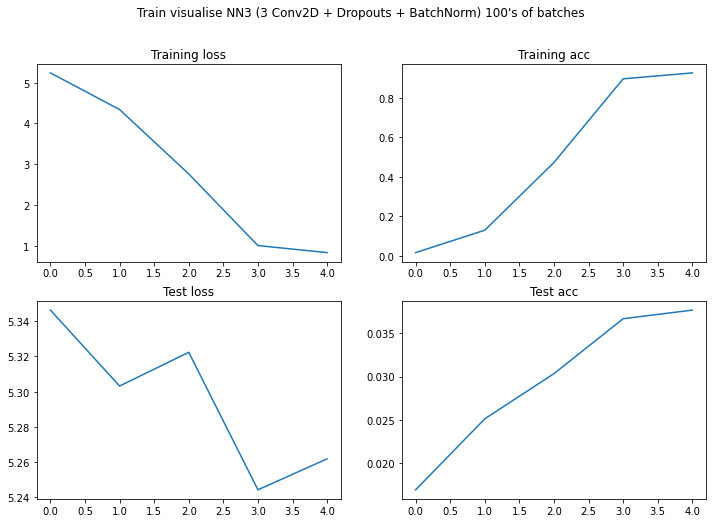

#### Model 4. Add BatchNorm  ####
Epoch 0/4
----------
train Loss: 5.2272176142994216 Acc: 0.014366404715127701
test Loss: 5.301028914689395 Acc: 0.01417734112672553

Epoch 1/4
----------
train Loss: 4.735736774789327 Acc: 0.06421905697445972
test Loss: 5.298975076415678 Acc: 0.015172242258425568

Epoch 2/4
----------
train Loss: 4.100323589002688 Acc: 0.16760805500982318
test Loss: 5.359400982080504 Acc: 0.02163909961447581

Epoch 3/4
----------
train Loss: 3.211107940242895 Acc: 0.40864440078585457
test Loss: 5.283923958741734 Acc: 0.02300708867056336

Epoch 4/4
----------
train Loss: 3.0634864402426247 Acc: 0.4447445972495088
test Loss: 5.2836870150310515 Acc: 0.024250715085188407



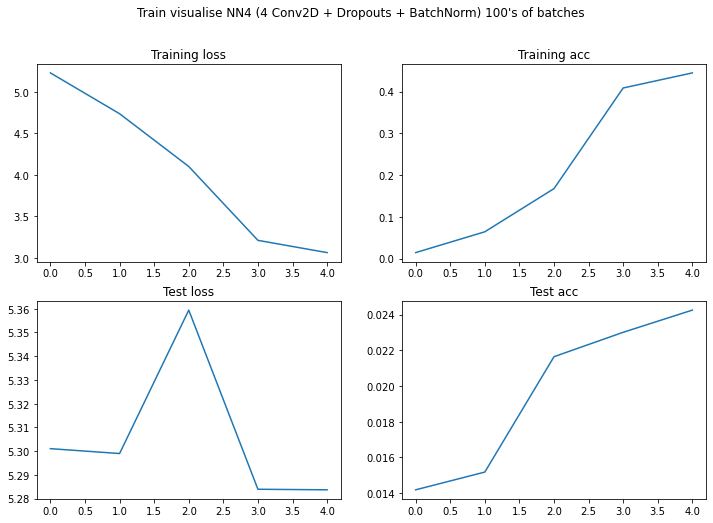

In [67]:
learning_rate = 0.001
models = [net1, net2, net3, net4]

for i in range(len(models)):
    print(f'#### Model {i+1}. Add BatchNorm  ####')
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(models[i].parameters(), lr=learning_rate, momentum=0.9)
    lrscheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
    model_ft, training_losses, training_accs, test_losses, test_accs = train_model(models[i], criterion, optimizer, lrscheduler, n_epochs=5)
    visual(training_losses, training_accs, test_losses, test_accs, f'NN{i+1} ({i+1} Conv2D + Dropouts + BatchNorm)')

As you can see, due to the fact that the model began to learn more effectively without disappearing or explosive gradients, with almost the same number of epochs, overfitting is formed earlier, but the results on the test are still better than before. In the future, I would try to increase the dropout percentage. On the positive side, we note that batch normalization smooths out the loss function.

> The standard normalization method is for each k, consider the distribution of batch elements. Subtract the mean and divide by the sample variance, obtaining a distribution centered at 0 and variance 1. Such a distribution will allow the network to learn faster, since all numbers will be of the same order. Better yet, introduce two variables for each feature, generalizing the normalization.

# Model configuration

Training convolutional neural networks is a random process. This makes experiments difficult because each time you run the same experiment, you get different results.

But if we start not only from the obtained graphs, but also from common sense, then I think the **latest models (add dropout, batchnorm and augmentation)** are the best option.

Perhaps they do not have the best results *(this is due to the limited resources of the GPU)*, but by the structure its are the most optimal. The only thing else that could be done was to play with the parameters a little longer (in dropout, the sizes of kernels, etc.)

# Layer sequence

I think the best option at the moment is a set of:
* Сonvolution layer
* Max Pooling
* Batch Normalization
* Dropout

* And their further unification, after which a fully-connected dense layer.

But it all depends on the experience of choosing good parameters for training a neural network. This sequence of layers is more likely to help you not overfit, more smoother and more effective learning. Also, this combination has performed well in most popular convolutional neural networks.

**Of the key rules that were traced in each network, we can single out:**
1. Start by using smaller filters to gather as much local information as possible, and then gradually increase the filter size to reduce the size of the generated function space to represent more global, high-level information.
2. The number of channels should be small at the beginning so that it detects low-level features that combine into many complex forms.
3. Typically 3x3, 5x5 and 7x7 filters are used for the convolutional layer for medium to small sized images, and for the Max-Pooling options we use 2x2 or 3x3 filter sizes in 2 steps.
4. Keep adding layers until you get overfit.

# Data Augmentation

Let's try to add **data augmentation** transformations. **Data augmentation** is a strategy that allows practitioners to dramatically increase the variety of data available for training models without actually collecting new data. For training large neural networks, data augmentation techniques such as cropping, filling and flipping horizontally are commonly used. However, most of the approaches used in training neural networks only use basic types of augmentation.
**Geometric transformations** work well when positional offsets are present in the images.

In [7]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((400, 400)),
        transforms.RandomHorizontalFlip(0.3),
        transforms.RandomRotation(15),
        transforms.ToTensor()
    ]),
    'test': transforms.Compose([
        transforms.Resize((400, 400)),
        transforms.ToTensor()
    ]),
}

batch_size = 32

image_datasets = {x: torchvision.datasets.ImageFolder(root=path_base+x, transform=data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

#### Model 3. Add Augmentation  ####
Epoch 0/9
----------
train Loss: 5.254227596088102 Acc: 0.015471512770137523
test Loss: 5.472959707305438 Acc: 0.013555527919413007

Epoch 1/9
----------
train Loss: 4.981936373270331 Acc: 0.03941552062868369
test Loss: 5.175076997157072 Acc: 0.027235418480288518

Epoch 2/9
----------
train Loss: 4.676127199573929 Acc: 0.07232318271119842
test Loss: 5.353935649925434 Acc: 0.026862330555901006

Epoch 3/9
----------
train Loss: 4.164347183025188 Acc: 0.15397838899803534
test Loss: 5.127030005073713 Acc: 0.0374331550802139

Epoch 4/9
----------
train Loss: 4.038120459948167 Acc: 0.17043222003929273
test Loss: 5.120100771813024 Acc: 0.040169133192389

Epoch 5/9
----------
train Loss: 3.9636718941109588 Acc: 0.18344793713163063
test Loss: 5.11832455849858 Acc: 0.04079094639970152

Epoch 6/9
----------
train Loss: 3.863435242171372 Acc: 0.20530451866404714
test Loss: 5.131256763710636 Acc: 0.039920407909463995

Epoch 7/9
----------
train Loss: 3.857139717

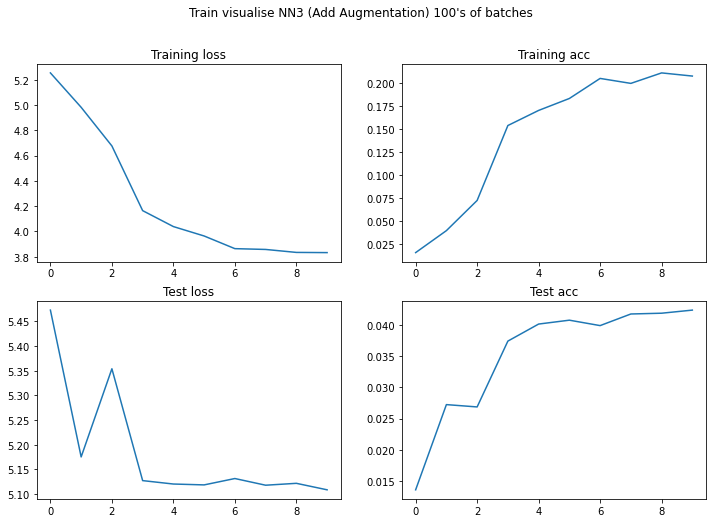

#### Model 4. Add Augmentation  ####
Epoch 0/9
----------
train Loss: 5.244314871040449 Acc: 0.011787819253438112
test Loss: 5.258745546142878 Acc: 0.010819549807237904

Epoch 1/9
----------
train Loss: 4.989150641240868 Acc: 0.034381139489194495
test Loss: 5.228186334518188 Acc: 0.018032583012063175

Epoch 2/9
----------
train Loss: 4.706191552879768 Acc: 0.05992141453831041
test Loss: 5.19991283170057 Acc: 0.022385275463250837

Epoch 3/9
----------
train Loss: 4.315406597901889 Acc: 0.12475442043222003
test Loss: 5.123348524166923 Acc: 0.027857231687601042

Epoch 4/9
----------
train Loss: 4.236735466655439 Acc: 0.13457760314341846
test Loss: 5.116608120437108 Acc: 0.027359781121751026

Epoch 5/9
----------
train Loss: 4.193396565487904 Acc: 0.13543713163064833
test Loss: 5.117365582222637 Acc: 0.027359781121751026

Epoch 6/9
----------
train Loss: 4.129754878683034 Acc: 0.15361001964636542
test Loss: 5.108485457879692 Acc: 0.027981594329063546

Epoch 7/9
----------
train Loss: 4.120

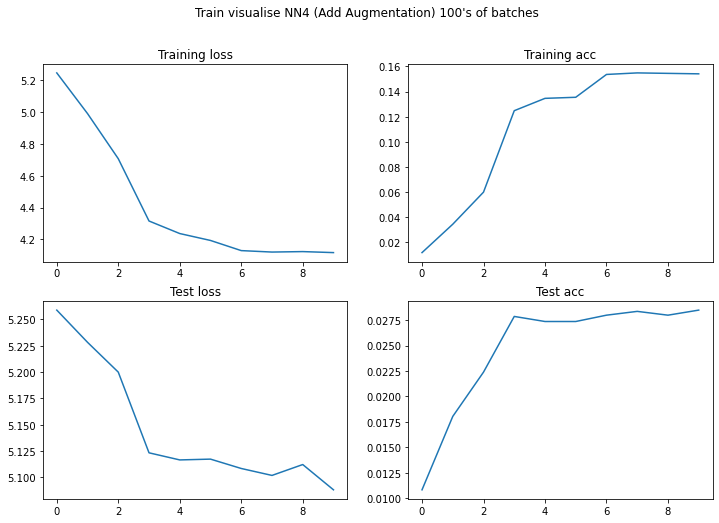

In [12]:
learning_rate = 0.001
net3 = ConvNet333()
net4 = ConvNet444()

models = [net3, net4]

for i in range(len(models)):
    print(f'#### Model {i+3}. Add Augmentation  ####')
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(models[i].parameters(), lr=learning_rate, momentum=0.9)
    lrscheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
    model_ft, training_losses, training_accs, test_losses, test_accs = train_model(models[i], criterion, optimizer, lrscheduler, n_epochs=10)
    visual(training_losses, training_accs, test_losses, test_accs, f'NN{i+3} (Add Augmentation)')

There is a longer learning curve, but by doing so we make our learning more meaningful. The model will learn from modified images to get more generalized filters in the future.

# Filters and activation maps

First convolutional layer


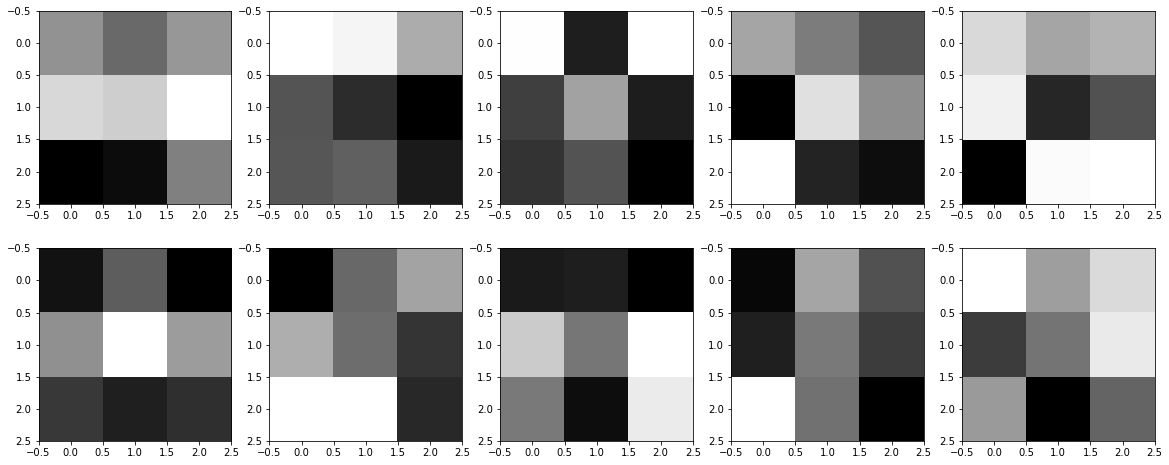

In [14]:
weights = net4.conv1.weight.data
w = weights.cpu().numpy()

fig=plt.figure(figsize=(20, 8))
columns = 5
rows = 2
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(w[i][0], cmap='gray')
    
print('First convolutional layer')
plt.show()


Last convolutional layer


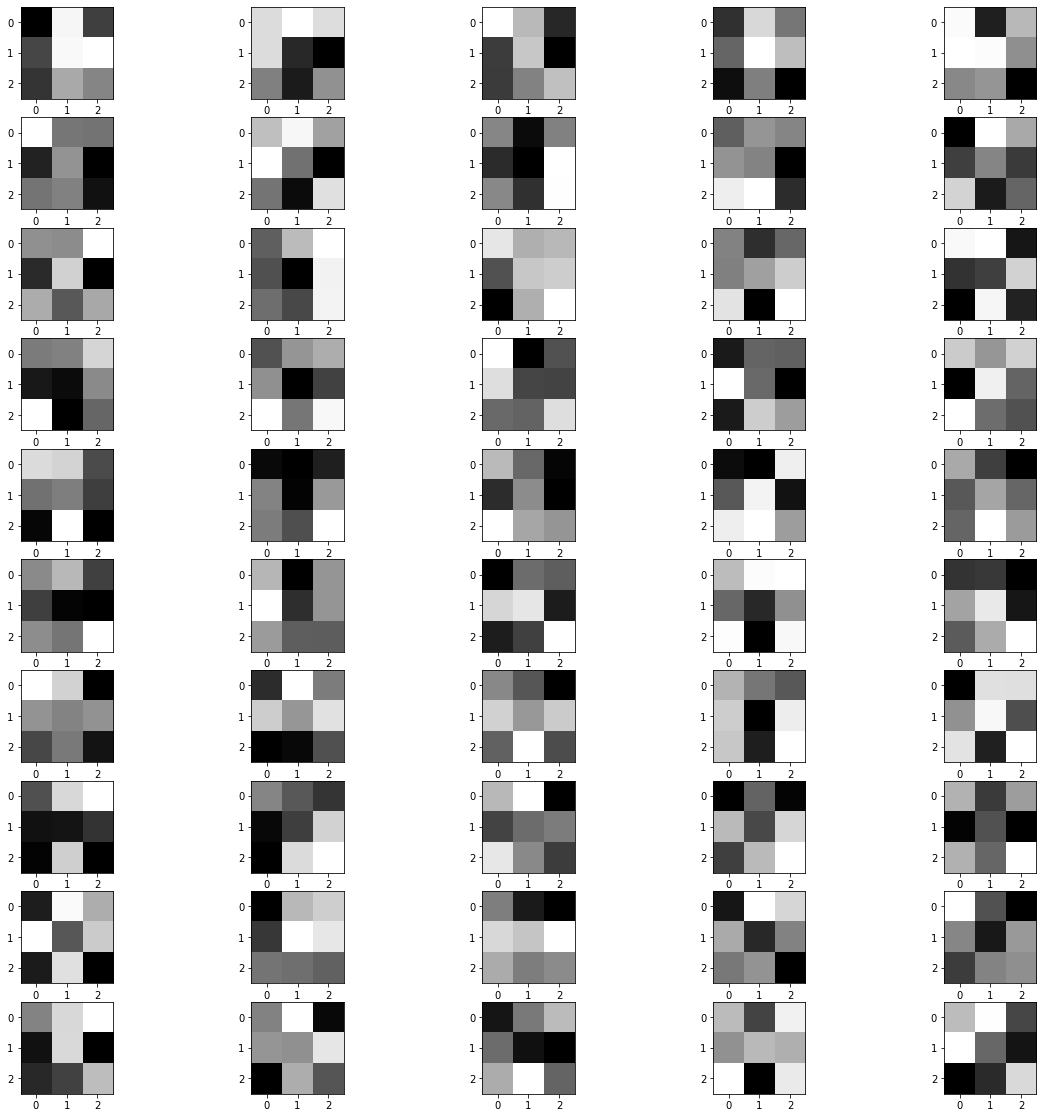

In [16]:
weights = net4.conv4.weight.data
w = weights.cpu().numpy()

fig=plt.figure(figsize=(20, 20))
columns = 5
rows = 10
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(w[i][0], cmap='gray')
    
print('Last convolutional layer')
plt.show()

As we can see, the model has learned quite well to predict vertical transitions, which can be traced on several filters. In our case, this is important, since the car can be described using simple lines, including vertical ones.

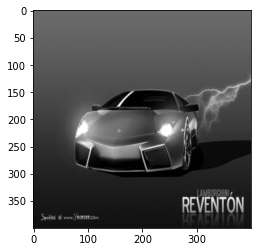

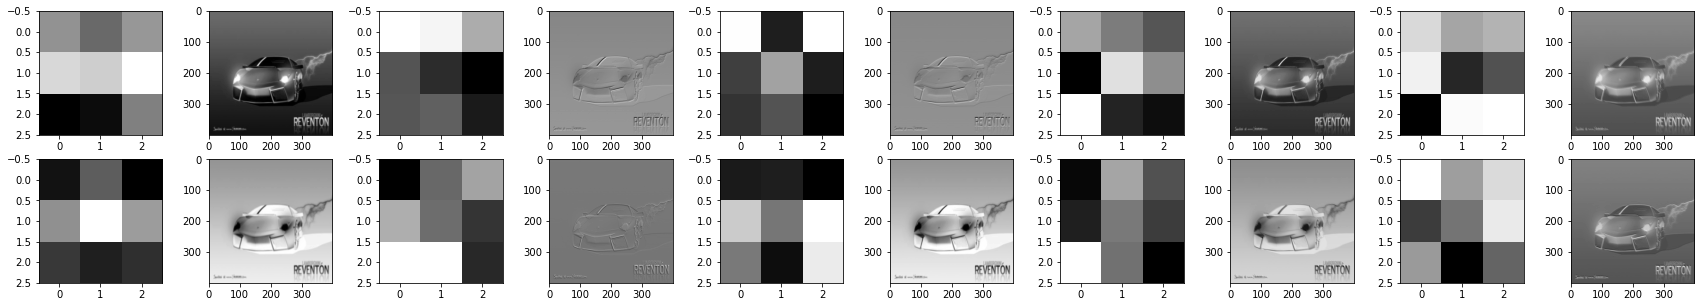

In [29]:
dataiter = iter(dataloaders['test'])
images, labels = dataiter.next()
images = images.numpy()

idx = 3
img = np.squeeze(images[idx][0,:,:])

import cv2
plt.imshow(img, cmap='gray')

weights = net4.conv1.weight.data
w = weights.cpu().numpy()

fig=plt.figure(figsize=(30, 5))
columns = 5*2
rows = 2
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    if ((i%2)==0):
        plt.imshow(w[int(i/2)][0], cmap='gray')
    else:
        c = cv2.filter2D(img, -1, w[int((i-1)/2)][0])
        plt.imshow(c, cmap='gray')
plt.show()

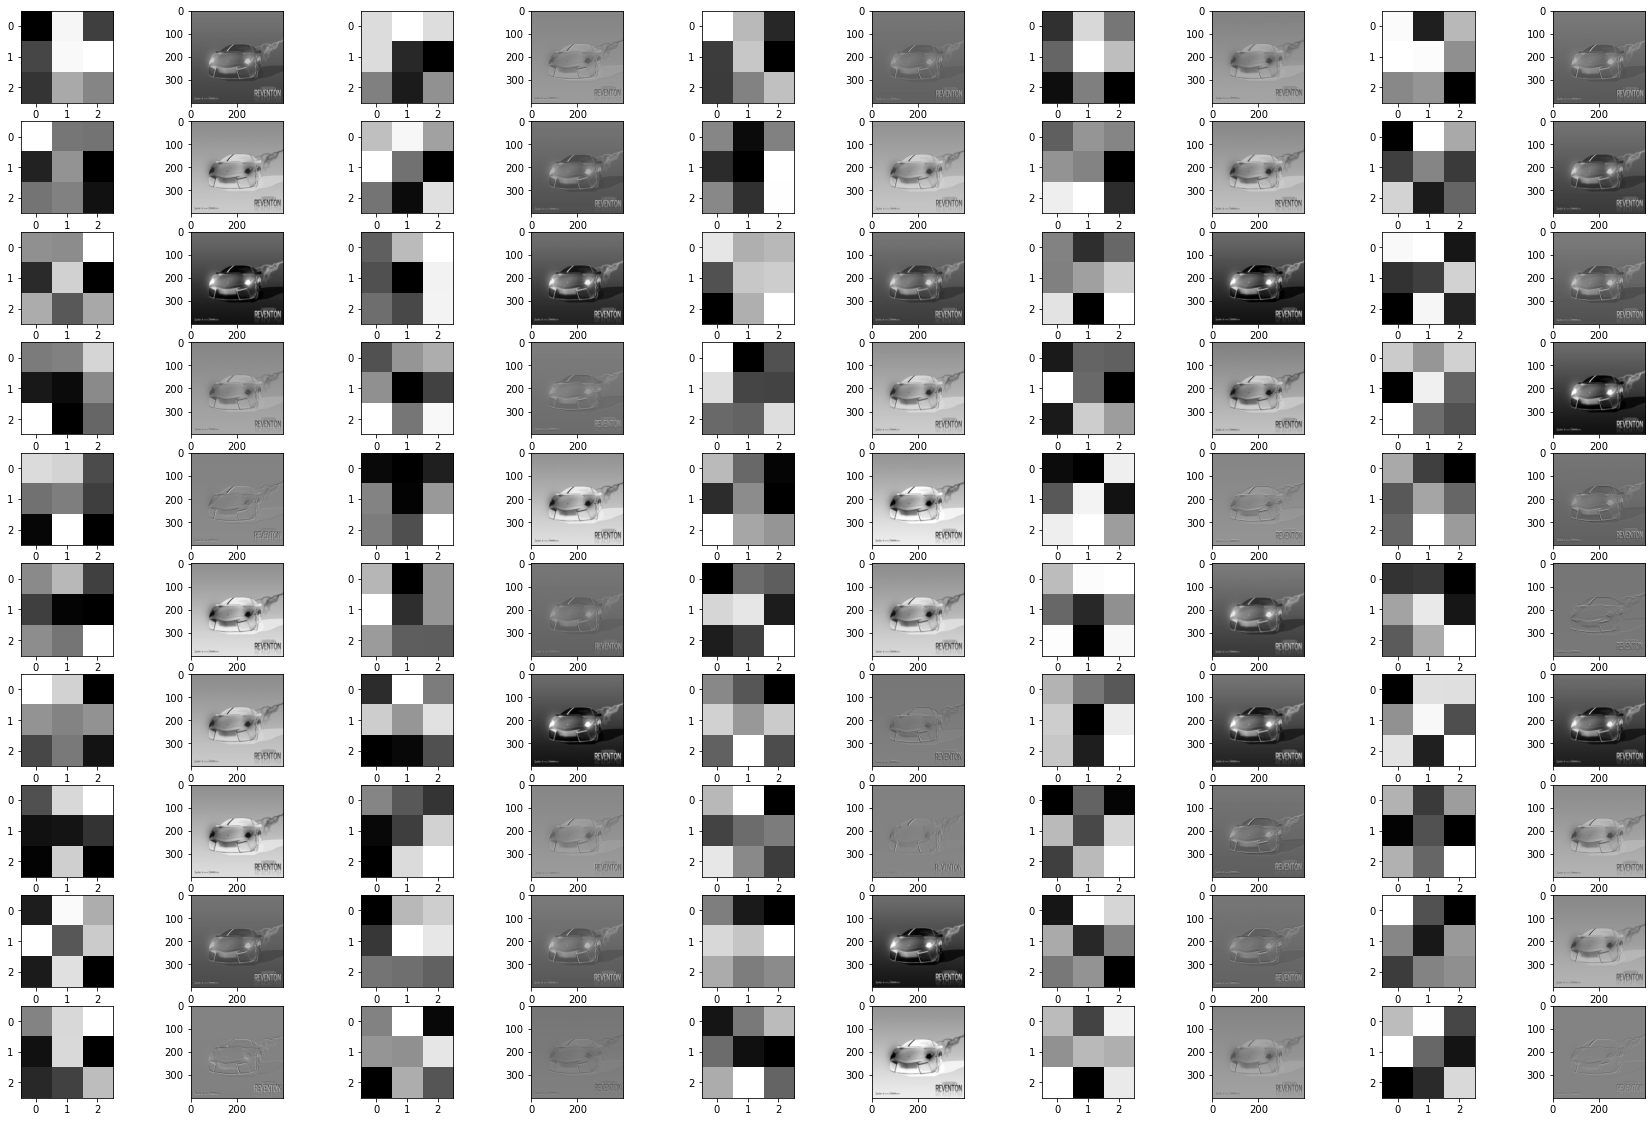

In [32]:
weights = net4.conv4.weight.data
w = weights.cpu().numpy()

fig=plt.figure(figsize=(30, 20))
columns = 5*2
rows = 10
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    if ((i%2)==0):
        plt.imshow(w[int(i/2)][0], cmap='gray')
    else:
        c = cv2.filter2D(img, -1, w[int((i-1)/2)][0])
        plt.imshow(c, cmap='gray')
plt.show()

# Pre-trained model: freeze

In [56]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

batch_size = 32

image_datasets = {x: torchvision.datasets.ImageFolder(root=path_base+x, transform=data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

In [54]:
model_conv = models.resnet34(pretrained=True)
num_ftrs = model_conv.fc.in_features

for param in model_conv.parameters():
    param.requires_grad = False

model_conv.fc = nn.Linear(num_ftrs, 196)
model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
lrscheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

In [55]:
print(f'#### Pre-trained Model ####')
model_ft, training_losses, training_accs, test_losses, test_accs = train_model(model_conv, criterion, optimizer, lrscheduler, n_epochs=5)
visual(training_losses, training_accs, test_losses, test_accs, 'NN Pre-trained Model')

####  Pre-trained Model ####
Epoch 0/9
----------
train Loss: 5.485268347389805 Acc: 0.005893909626719056
test Loss: 5.480847358822214 Acc: 0.006591219997512747

Epoch 1/9
----------
train Loss: 5.4890671853700645 Acc: 0.006262278978388998
test Loss: 5.483084904289174 Acc: 0.005969406790200223

Epoch 2/9
----------


KeyboardInterrupt: 

The results are not impressive because we did not retrain the pre-train model for our dataset. Most likely, the training dataset for the resnet contained pictures on a different topic, or there were few machines. Therefore filters with freeze scales capture other information.

# Pre-trained model: fine-tuning

In [62]:
model_ft = models.resnet34(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 196)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
lrscheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

#### Fine-Tuning Model ####
Epoch 0/4
----------
train Loss: 3.807071095131235 Acc: 0.17608055009823181
test Loss: 2.8645324116395994 Acc: 0.29299838328566097

Epoch 1/4
----------
train Loss: 1.768071712351501 Acc: 0.5197691552062867
test Loss: 2.5334467128236087 Acc: 0.35629896779007586

Epoch 2/4
----------
train Loss: 1.0738544637421494 Acc: 0.6889734774066797
test Loss: 1.325443105634773 Acc: 0.6243004601417733

Epoch 3/4
----------
train Loss: 0.4445588901375506 Acc: 0.8861738703339882
test Loss: 0.6099811773286236 Acc: 0.8250217634622559

Epoch 4/4
----------
train Loss: 0.2968634357328265 Acc: 0.930500982318271
test Loss: 0.5641124015749279 Acc: 0.8375823902499688



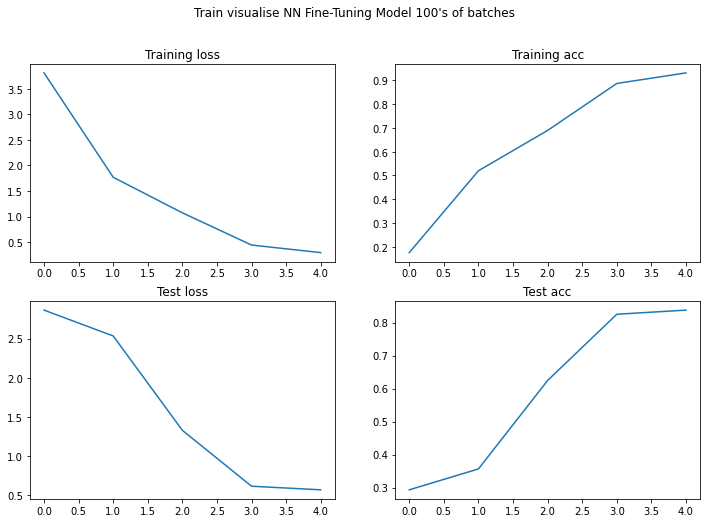

In [63]:
print(f'#### Fine-Tuning Model ####')
model_ft, training_losses, training_accs, test_losses, test_accs = train_model(model_ft, criterion, optimizer, lrscheduler, n_epochs=5)
visual(training_losses, training_accs, test_losses, test_accs, 'NN Fine-Tuning Model')

The result is impressive! A large increase in accuracy on a test dataset and without much overfit. This is due to the fact that we have already trained weights, which gave good results on various benchmarks, adjusted to our dataset. Thus, they worked not with randomly initiated quantities, but prepared in advance. Those. we move with our data deep into the neural network and, starting from the very beginning, adjust the weights to our task.

This is the difference with the previous approach, when we fixed everything and changed only the last layer on the output.